# 04. Clustering Analysis (AUTO K-SELECTION)

This notebook implements texture space analysis through:
- Feature standardization
- PCA dimensionality reduction (1351D → 50D)
- **AUTOMATIC K selection** using 4 methods:
  - Silhouette Score (primary)
  - Calinski-Harabasz Score
  - Davies-Bouldin Score
  - Elbow Method
- K-means clustering (auto-selected k)
- Hierarchical clustering (Ward linkage)
- Cluster profiling and interpretation

**Author**: Kuan-Chen, Chen  
**Reference**: README.md Section "3. Dimensionality Reduction" and "4. Clustering Analysis"

**New Feature**: Set `AUTO_SELECT_K = True` to automatically find optimal K value!

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Clustering Parameters (from README.md)

In [2]:
# PCA parameters
N_COMPONENTS = 50                     # Number of principal components
EXPLAINED_VARIANCE_THRESHOLD = 0.95   # Retain 95% variance

# K-means parameters - AUTO SELECTION MODE
AUTO_SELECT_K = True                  # Set to True for automatic K selection
K_RANGE = range(2, 11)                # Range of K values to test
MANUAL_K = 5                          # Manual K value (used only if AUTO_SELECT_K=False)

KMEANS_N_INIT = 100                   # Number of initializations
KMEANS_MAX_ITER = 300
KMEANS_RANDOM_STATE = 42

# Hierarchical clustering parameters
LINKAGE_METHOD = 'ward'
AFFINITY_METRIC = 'euclidean'

print("Clustering Parameters:")
print(f"  PCA components: {N_COMPONENTS}")
print(f"  Auto-select K: {AUTO_SELECT_K}")
if AUTO_SELECT_K:
    print(f"  K search range: {K_RANGE.start} to {K_RANGE.stop-1}")
else:
    print(f"  Manual K: {MANUAL_K}")
print(f"  K-means initializations: {KMEANS_N_INIT}")
print(f"  Hierarchical linkage: {LINKAGE_METHOD}")

Clustering Parameters:
  PCA components: 50
  Auto-select K: True
  K search range: 2 to 10
  K-means initializations: 100
  Hierarchical linkage: ward


## 3. Load Extracted Features

In [3]:
BASE_DIR = Path('..').resolve()

# Load features (assuming you ran notebook 03)
FEATURES_PATH = BASE_DIR / 'features_train.pkl'

if not FEATURES_PATH.exists():
    print("⚠️  Features file not found!")
    print("   Please run notebook 03 first to extract features.")
    print(f"   Expected path: {FEATURES_PATH}")
else:
    with open(FEATURES_PATH, 'rb') as f:
        features_data = pickle.load(f)
    
    features = features_data['features']
    labels = features_data['labels']
    class_to_idx = features_data['class_to_idx']
    idx_to_class = features_data['idx_to_class']
    
    print(f"✓ Features loaded successfully!")
    print(f"  Shape: {features.shape}")
    print(f"  Number of samples: {len(features)}")
    print(f"  Feature dimensions: {features.shape[1]}")
    print(f"  Number of classes: {len(class_to_idx)}")
    print(f"\nClass distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for idx, count in zip(unique, counts):
        print(f"  {idx_to_class[idx]}: {count} samples")

✓ Features loaded successfully!
  Shape: (500, 1351)
  Number of samples: 500
  Feature dimensions: 1351
  Number of classes: 10

Class distribution:
  Tomato___Bacterial_spot: 50 samples
  Tomato___Early_blight: 50 samples
  Tomato___healthy: 50 samples
  Tomato___Late_blight: 50 samples
  Tomato___Leaf_Mold: 50 samples
  Tomato___Septoria_leaf_spot: 50 samples
  Tomato___Spider_mites Two-spotted_spider_mite: 50 samples
  Tomato___Target_Spot: 50 samples
  Tomato___Tomato_mosaic_virus: 50 samples
  Tomato___Tomato_Yellow_Leaf_Curl_Virus: 50 samples


## 4. Feature Standardization

In [4]:
# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("Feature Standardization:")
print(f"  Original - Mean: {features.mean():.4f}, Std: {features.std():.4f}")
print(f"  Scaled   - Mean: {features_scaled.mean():.4f}, Std: {features_scaled.std():.4f}")
print(f"\n✓ Features standardized (zero mean, unit variance)")

Feature Standardization:
  Original - Mean: 11.6544, Std: 163.1477
  Scaled   - Mean: 0.0000, Std: 1.0000

✓ Features standardized (zero mean, unit variance)


## 5. PCA Dimensionality Reduction

In [5]:
# Apply PCA
print(f"Applying PCA: {features_scaled.shape[1]}D → {N_COMPONENTS}D...\n")

pca = PCA(n_components=N_COMPONENTS, random_state=42)
features_pca = pca.fit_transform(features_scaled)

# Calculate cumulative explained variance
explained_variance_cumsum = np.cumsum(pca.explained_variance_ratio_)

print("PCA Results:")
print(f"  Original dimensions: {features_scaled.shape[1]}")
print(f"  Reduced dimensions: {features_pca.shape[1]}")
print(f"  Explained variance (total): {explained_variance_cumsum[-1]:.4f} ({explained_variance_cumsum[-1]*100:.2f}%)")
print(f"  Explained variance (PC1): {pca.explained_variance_ratio_[0]:.4f} ({pca.explained_variance_ratio_[0]*100:.2f}%)")
print(f"  Explained variance (PC2): {pca.explained_variance_ratio_[1]:.4f} ({pca.explained_variance_ratio_[1]*100:.2f}%)")
print(f"  Explained variance (PC3): {pca.explained_variance_ratio_[2]:.4f} ({pca.explained_variance_ratio_[2]*100:.2f}%)")

# Find how many components needed for 95% variance
n_for_95 = np.argmax(explained_variance_cumsum >= 0.95) + 1
print(f"\n  Components needed for 95% variance: {n_for_95}")

Applying PCA: 1351D → 50D...

PCA Results:
  Original dimensions: 1351
  Reduced dimensions: 50
  Explained variance (total): 0.7074 (70.74%)
  Explained variance (PC1): 0.0700 (7.00%)
  Explained variance (PC2): 0.0587 (5.87%)
  Explained variance (PC3): 0.0444 (4.44%)

  Components needed for 95% variance: 1


## 6. Visualize Explained Variance

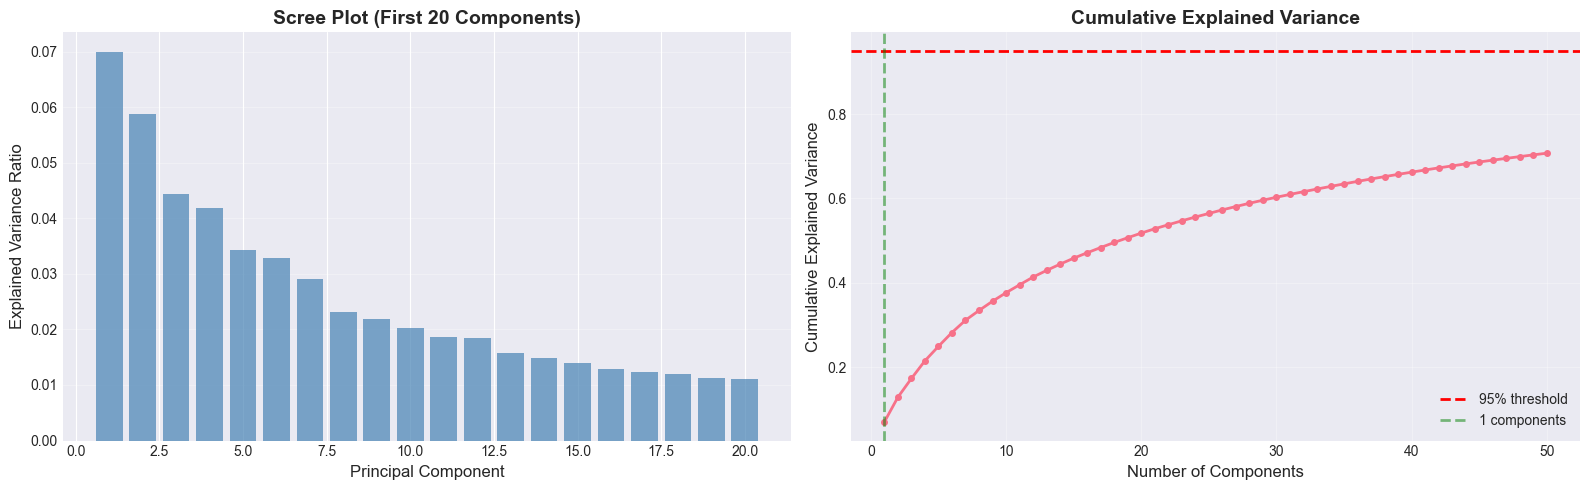


✓ PCA visualization complete


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot
axes[0].bar(range(1, 21), pca.explained_variance_ratio_[:20], alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot (First 20 Components)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Cumulative explained variance
axes[1].plot(range(1, N_COMPONENTS+1), explained_variance_cumsum, 'o-', linewidth=2, markersize=4)
axes[1].axhline(y=0.95, color='r', linestyle='--', linewidth=2, label='95% threshold')
axes[1].axvline(x=n_for_95, color='g', linestyle='--', linewidth=2, alpha=0.5, label=f'{n_for_95} components')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'pca_variance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ PCA visualization complete")

## 7. Optimal K Selection (4 Methods)

Testing different k values for K-means...



100%|██████████| 9/9 [00:02<00:00,  3.10it/s]



AUTOMATIC K SELECTION RESULTS
  Method 1 - Silhouette Score:     k = 10 (score: 0.0798)
  Method 2 - Calinski-Harabasz:    k = 2 (score: 35.27)
  Method 3 - Davies-Bouldin:       k = 10 (score: 2.2939)
  Method 4 - Elbow Method:         k = 6

✓ SELECTED K = 10 (based on Silhouette score)
  Silhouette: 0.0798
  Calinski-Harabasz: 23.61
  Davies-Bouldin: 2.2939


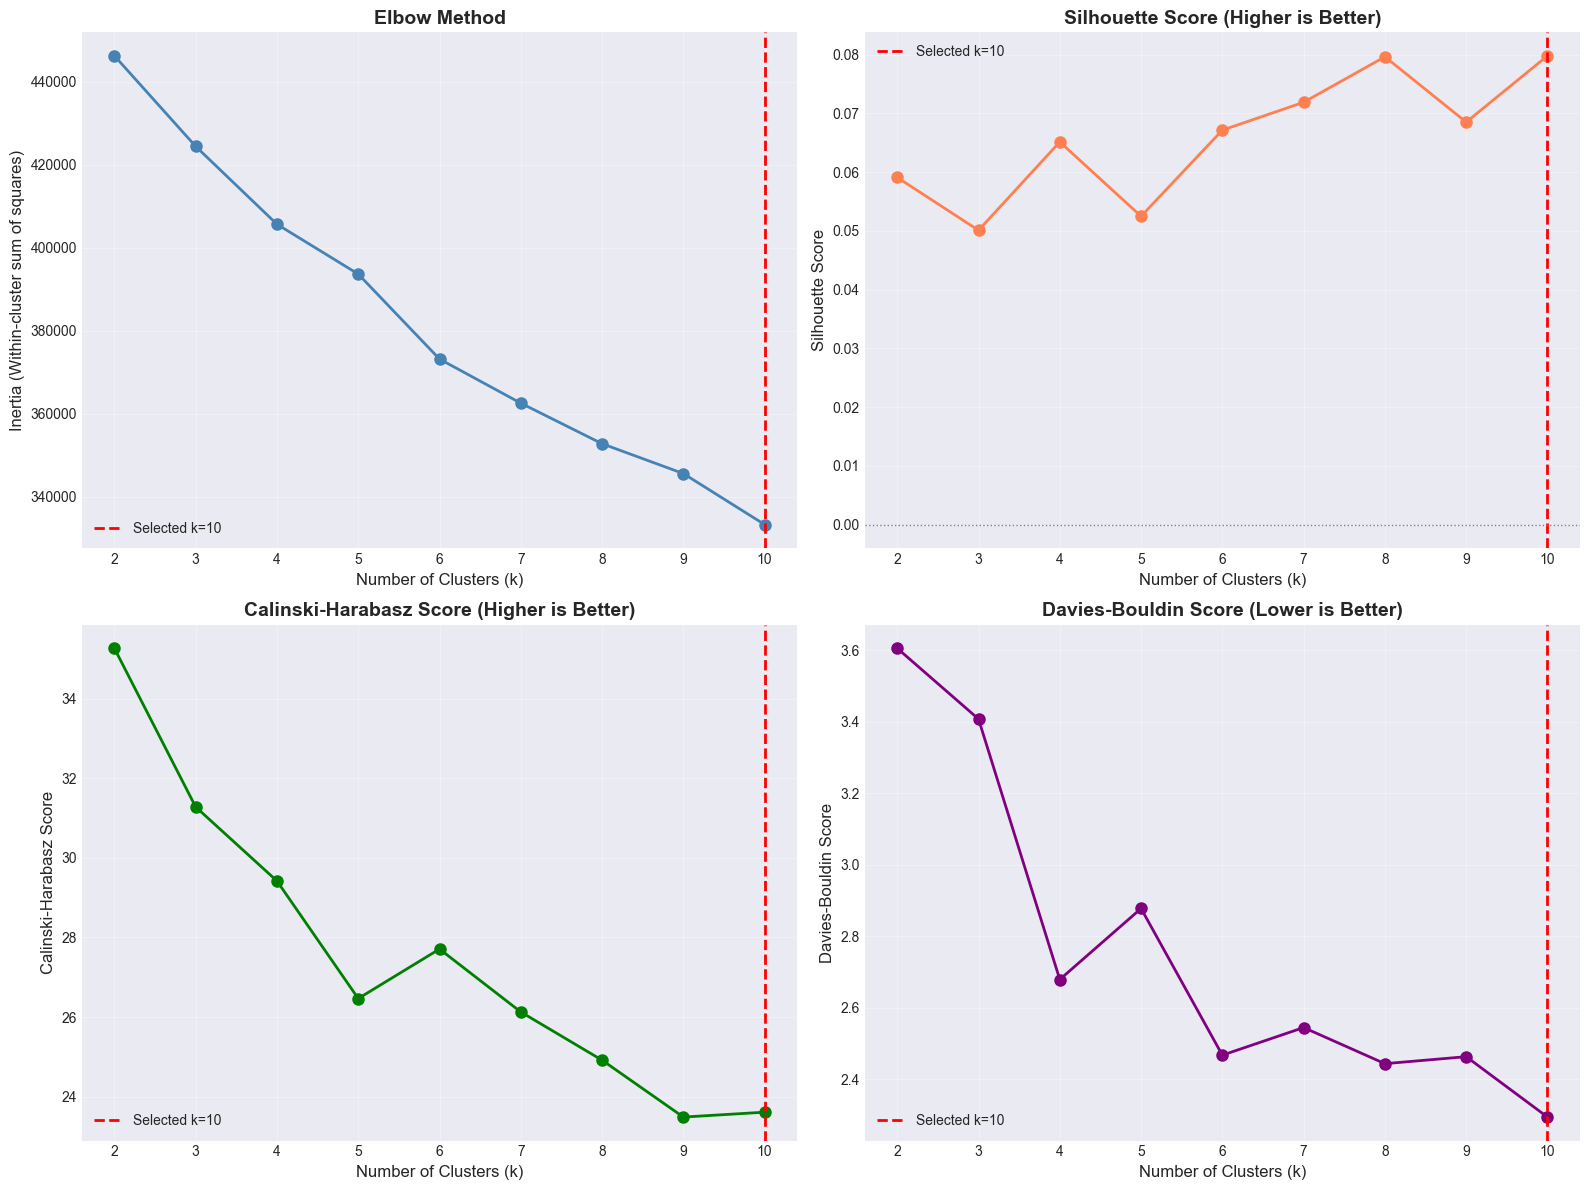


✓ Optimal K selection complete
  Final K = 10


In [7]:
# Test different k values
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("Testing different k values for K-means...\n")

for k in tqdm(K_RANGE):
    kmeans_test = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_test = kmeans_test.fit_predict(features_pca)
    
    inertias.append(kmeans_test.inertia_)
    silhouette_scores.append(silhouette_score(features_pca, labels_test))
    calinski_scores.append(calinski_harabasz_score(features_pca, labels_test))
    davies_bouldin_scores.append(davies_bouldin_score(features_pca, labels_test))

# Automatic K selection based on multiple criteria
if AUTO_SELECT_K:
    # Method 1: Maximum Silhouette score
    optimal_k_silhouette = K_RANGE[np.argmax(silhouette_scores)]
    
    # Method 2: Maximum Calinski-Harabasz score
    optimal_k_calinski = K_RANGE[np.argmax(calinski_scores)]
    
    # Method 3: Minimum Davies-Bouldin score
    optimal_k_davies = K_RANGE[np.argmin(davies_bouldin_scores)]
    
    # Method 4: Elbow method (using second derivative)
    # Calculate rate of change in inertia
    deltas = np.diff(inertias)
    second_deltas = np.diff(deltas)
    optimal_k_elbow = K_RANGE[np.argmin(second_deltas) + 2] if len(second_deltas) > 0 else optimal_k_silhouette
    
    print("\n" + "="*70)
    print("AUTOMATIC K SELECTION RESULTS")
    print("="*70)
    print(f"  Method 1 - Silhouette Score:     k = {optimal_k_silhouette} (score: {silhouette_scores[optimal_k_silhouette-K_RANGE.start]:.4f})")
    print(f"  Method 2 - Calinski-Harabasz:    k = {optimal_k_calinski} (score: {calinski_scores[optimal_k_calinski-K_RANGE.start]:.2f})")
    print(f"  Method 3 - Davies-Bouldin:       k = {optimal_k_davies} (score: {davies_bouldin_scores[optimal_k_davies-K_RANGE.start]:.4f})")
    print(f"  Method 4 - Elbow Method:         k = {optimal_k_elbow}")
    print("="*70)
    
    # Final selection: Use Silhouette score (most reliable for quality)
    N_CLUSTERS_KMEANS = optimal_k_silhouette
    print(f"\n✓ SELECTED K = {N_CLUSTERS_KMEANS} (based on Silhouette score)")
    print(f"  Silhouette: {silhouette_scores[N_CLUSTERS_KMEANS-K_RANGE.start]:.4f}")
    print(f"  Calinski-Harabasz: {calinski_scores[N_CLUSTERS_KMEANS-K_RANGE.start]:.2f}")
    print(f"  Davies-Bouldin: {davies_bouldin_scores[N_CLUSTERS_KMEANS-K_RANGE.start]:.4f}")
else:
    N_CLUSTERS_KMEANS = MANUAL_K
    optimal_k_silhouette = MANUAL_K
    print(f"\n✓ Using manual K = {N_CLUSTERS_KMEANS}")

# Also use same K for hierarchical clustering
N_CLUSTERS_HIERARCHICAL = N_CLUSTERS_KMEANS

# Plot comprehensive evaluation
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Inertia (elbow method)
axes[0, 0].plot(K_RANGE, inertias, 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].axvline(x=N_CLUSTERS_KMEANS, color='r', linestyle='--', linewidth=2, 
                   label=f'Selected k={N_CLUSTERS_KMEANS}')
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Silhouette score
axes[0, 1].plot(K_RANGE, silhouette_scores, 'o-', linewidth=2, markersize=8, color='coral')
axes[0, 1].axvline(x=N_CLUSTERS_KMEANS, color='r', linestyle='--', linewidth=2, 
                   label=f'Selected k={N_CLUSTERS_KMEANS}')
axes[0, 1].axhline(y=0, color='gray', linestyle=':', linewidth=1)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Calinski-Harabasz score
axes[1, 0].plot(K_RANGE, calinski_scores, 'o-', linewidth=2, markersize=8, color='green')
axes[1, 0].axvline(x=N_CLUSTERS_KMEANS, color='r', linestyle='--', linewidth=2, 
                   label=f'Selected k={N_CLUSTERS_KMEANS}')
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 0].set_title('Calinski-Harabasz Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Davies-Bouldin score
axes[1, 1].plot(K_RANGE, davies_bouldin_scores, 'o-', linewidth=2, markersize=8, color='purple')
axes[1, 1].axvline(x=N_CLUSTERS_KMEANS, color='r', linestyle='--', linewidth=2, 
                   label=f'Selected k={N_CLUSTERS_KMEANS}')
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=12)
axes[1, 1].set_title('Davies-Bouldin Score (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'optimal_k_selection.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Optimal K selection complete")
print(f"  Final K = {N_CLUSTERS_KMEANS}")

## 8. K-Means Clustering

In [8]:
print(f"Applying K-means clustering (k={N_CLUSTERS_KMEANS})...\n")

kmeans = KMeans(
    n_clusters=N_CLUSTERS_KMEANS,
    init='k-means++',
    n_init=KMEANS_N_INIT,
    max_iter=KMEANS_MAX_ITER,
    random_state=KMEANS_RANDOM_STATE
)

labels_kmeans = kmeans.fit_predict(features_pca)

# Clustering metrics
silhouette_kmeans = silhouette_score(features_pca, labels_kmeans)
calinski_kmeans = calinski_harabasz_score(features_pca, labels_kmeans)
davies_bouldin_kmeans = davies_bouldin_score(features_pca, labels_kmeans)

print("K-Means Results:")
print(f"  Number of clusters: {N_CLUSTERS_KMEANS}")
print(f"  Inertia: {kmeans.inertia_:.2f}")
print(f"  Silhouette score: {silhouette_kmeans:.4f} (higher is better, range [-1, 1])")
print(f"  Calinski-Harabasz: {calinski_kmeans:.2f} (higher is better)")
print(f"  Davies-Bouldin: {davies_bouldin_kmeans:.4f} (lower is better)")

print(f"\nCluster sizes:")
unique, counts = np.unique(labels_kmeans, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(labels_kmeans)*100:.1f}%)")

Applying K-means clustering (k=10)...

K-Means Results:
  Number of clusters: 10
  Inertia: 333219.20
  Silhouette score: 0.0801 (higher is better, range [-1, 1])
  Calinski-Harabasz: 23.63 (higher is better)
  Davies-Bouldin: 2.2695 (lower is better)

Cluster sizes:
  Cluster 0: 46 samples (9.2%)
  Cluster 1: 44 samples (8.8%)
  Cluster 2: 52 samples (10.4%)
  Cluster 3: 4 samples (0.8%)
  Cluster 4: 23 samples (4.6%)
  Cluster 5: 80 samples (16.0%)
  Cluster 6: 41 samples (8.2%)
  Cluster 7: 97 samples (19.4%)
  Cluster 8: 25 samples (5.0%)
  Cluster 9: 88 samples (17.6%)


## 9. Hierarchical Clustering

In [9]:
print(f"Applying Hierarchical clustering ({LINKAGE_METHOD} linkage)...\n")

hierarchical = AgglomerativeClustering(
    n_clusters=N_CLUSTERS_HIERARCHICAL,
    linkage=LINKAGE_METHOD,
    metric=AFFINITY_METRIC  # Changed from 'affinity' to 'metric' for scikit-learn 1.0+
)

labels_hierarchical = hierarchical.fit_predict(features_pca)

# Clustering metrics
silhouette_hier = silhouette_score(features_pca, labels_hierarchical)
calinski_hier = calinski_harabasz_score(features_pca, labels_hierarchical)
davies_bouldin_hier = davies_bouldin_score(features_pca, labels_hierarchical)

print("Hierarchical Clustering Results:")
print(f"  Number of clusters: {N_CLUSTERS_HIERARCHICAL}")
print(f"  Linkage method: {LINKAGE_METHOD}")
print(f"  Silhouette score: {silhouette_hier:.4f}")
print(f"  Calinski-Harabasz: {calinski_hier:.2f}")
print(f"  Davies-Bouldin: {davies_bouldin_hier:.4f}")

print(f"\nCluster sizes:")
unique, counts = np.unique(labels_hierarchical, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(labels_hierarchical)*100:.1f}%)")

Applying Hierarchical clustering (ward linkage)...

Hierarchical Clustering Results:
  Number of clusters: 10
  Linkage method: ward
  Silhouette score: 0.0669
  Calinski-Harabasz: 21.03
  Davies-Bouldin: 2.5526

Cluster sizes:
  Cluster 0: 68 samples (13.6%)
  Cluster 1: 107 samples (21.4%)
  Cluster 2: 26 samples (5.2%)
  Cluster 3: 76 samples (15.2%)
  Cluster 4: 57 samples (11.4%)
  Cluster 5: 4 samples (0.8%)
  Cluster 6: 20 samples (4.0%)
  Cluster 7: 65 samples (13.0%)
  Cluster 8: 40 samples (8.0%)
  Cluster 9: 37 samples (7.4%)


## 10. Dendrogram Visualization

Creating dendrogram with 200 samples...


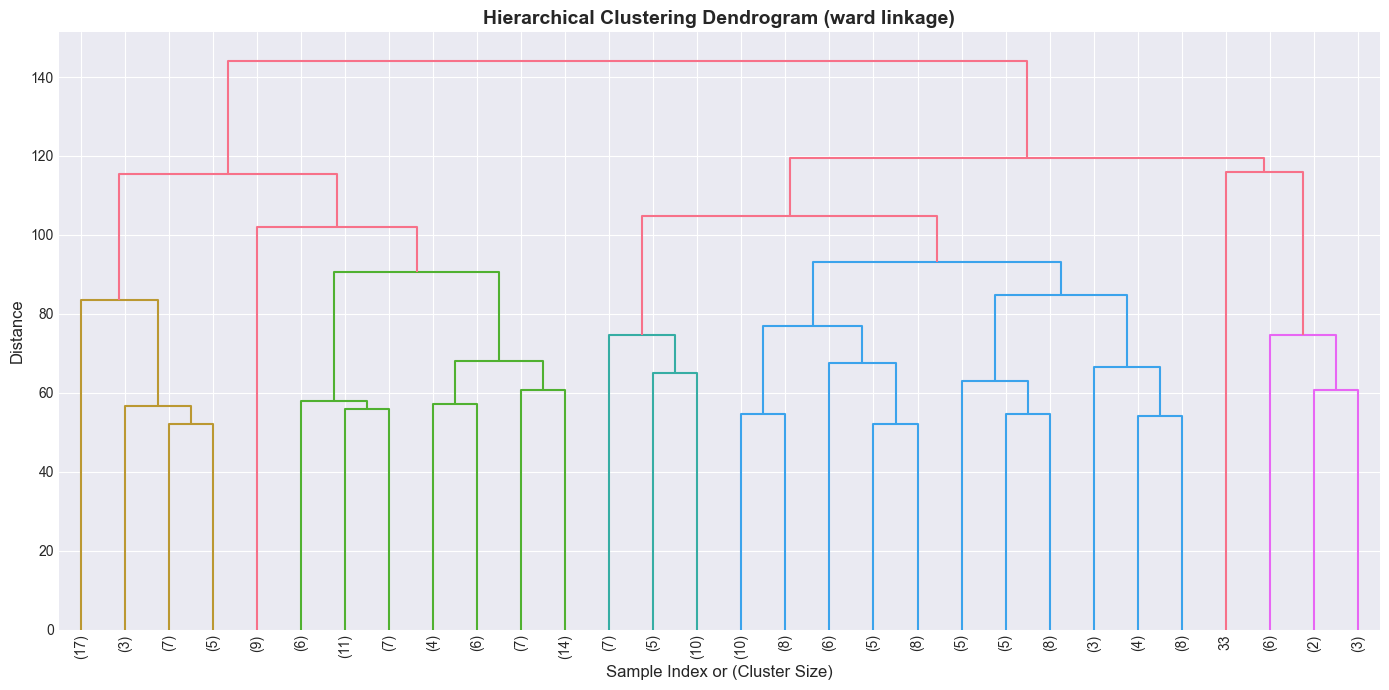

✓ Dendrogram complete


In [10]:
# Create linkage matrix for dendrogram
# Use a subset for visualization (dendrogram with all samples is too dense)
sample_size = min(200, len(features_pca))
sample_indices = np.random.choice(len(features_pca), sample_size, replace=False)
features_sample = features_pca[sample_indices]

print(f"Creating dendrogram with {sample_size} samples...")

linkage_matrix = linkage(features_sample, method=LINKAGE_METHOD)

plt.figure(figsize=(14, 7))
dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90,
    leaf_font_size=10
)
plt.title(f'Hierarchical Clustering Dendrogram ({LINKAGE_METHOD} linkage)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'dendrogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Dendrogram complete")

## 11. 2D Texture Space Visualization

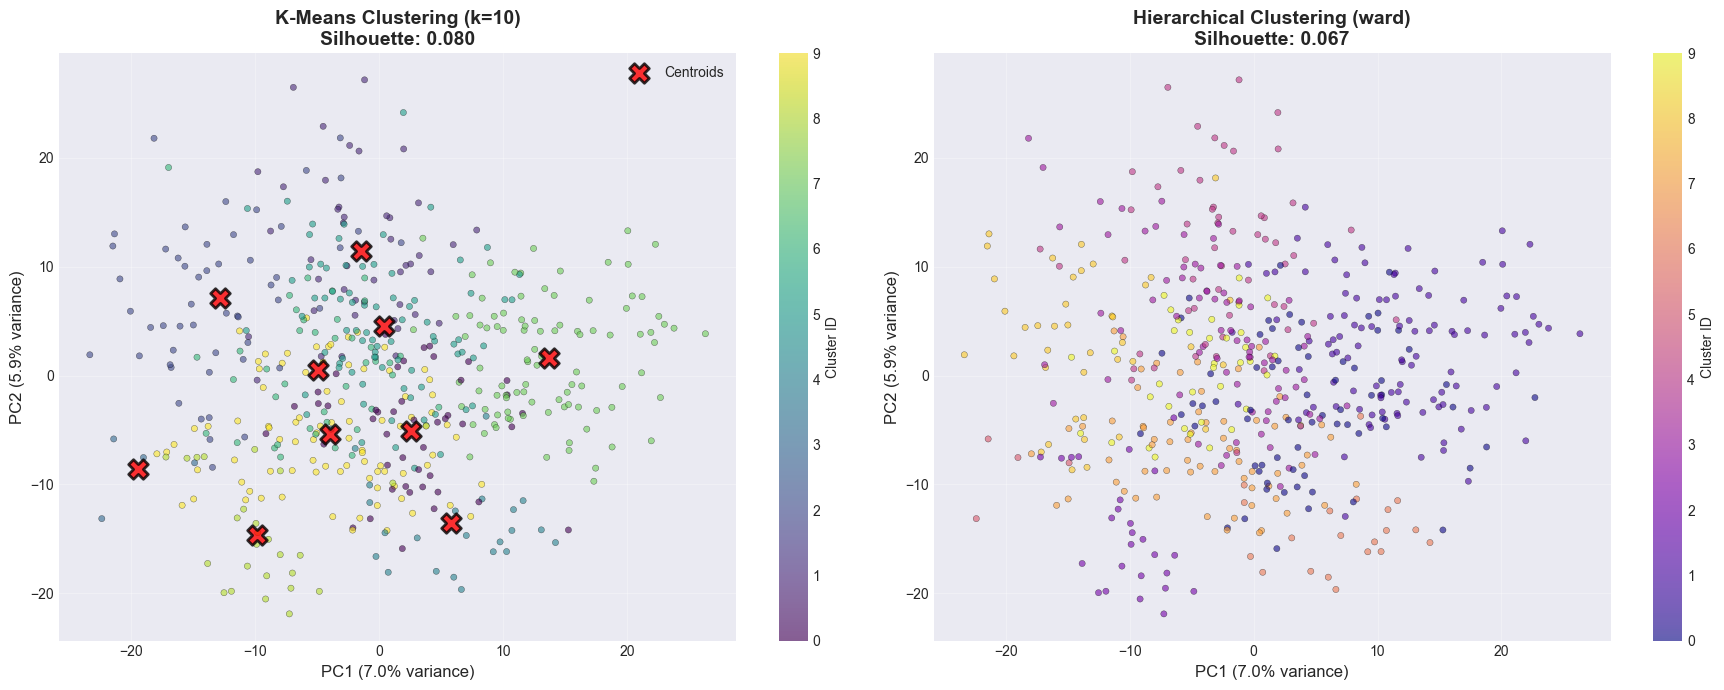

✓ 2D texture space visualization complete


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-means clusters
scatter1 = axes[0].scatter(
    features_pca[:, 0],
    features_pca[:, 1],
    c=labels_kmeans,
    cmap='viridis',
    s=20,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.3
)

# Plot cluster centroids
centroids = kmeans.cluster_centers_
axes[0].scatter(
    centroids[:, 0],
    centroids[:, 1],
    c='red',
    s=200,
    alpha=0.8,
    edgecolors='black',
    linewidth=2,
    marker='X',
    label='Centroids'
)

axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
axes[0].set_title(f'K-Means Clustering (k={N_CLUSTERS_KMEANS})\nSilhouette: {silhouette_kmeans:.3f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# Hierarchical clusters
scatter2 = axes[1].scatter(
    features_pca[:, 0],
    features_pca[:, 1],
    c=labels_hierarchical,
    cmap='plasma',
    s=20,
    alpha=0.6,
    edgecolors='k',
    linewidth=0.3
)

axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)
axes[1].set_title(f'Hierarchical Clustering ({LINKAGE_METHOD})\nSilhouette: {silhouette_hier:.3f}', 
                  fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Cluster ID')

plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'texture_space_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 2D texture space visualization complete")

## 12. 3D Texture Space Visualization

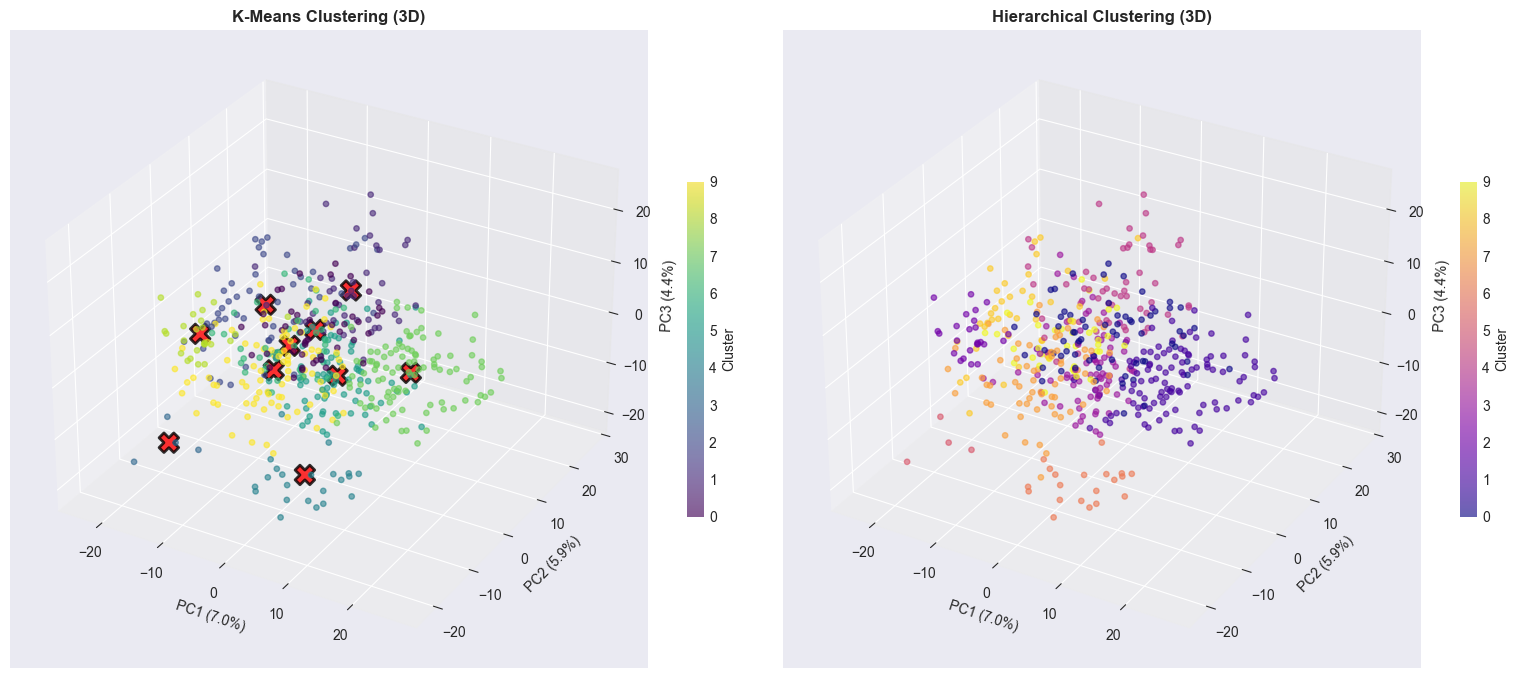

✓ 3D texture space visualization complete


In [12]:
fig = plt.figure(figsize=(16, 7))

# K-means 3D
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(
    features_pca[:, 0],
    features_pca[:, 1],
    features_pca[:, 2],
    c=labels_kmeans,
    cmap='viridis',
    s=15,
    alpha=0.6
)

# Centroids
ax1.scatter(
    centroids[:, 0],
    centroids[:, 1],
    centroids[:, 2],
    c='red',
    s=200,
    alpha=0.8,
    edgecolors='black',
    linewidth=2,
    marker='X'
)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10)
ax1.set_title('K-Means Clustering (3D)', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, shrink=0.5, label='Cluster')

# Hierarchical 3D
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(
    features_pca[:, 0],
    features_pca[:, 1],
    features_pca[:, 2],
    c=labels_hierarchical,
    cmap='plasma',
    s=15,
    alpha=0.6
)

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10)
ax2.set_title('Hierarchical Clustering (3D)', fontsize=12, fontweight='bold')
plt.colorbar(scatter2, ax=ax2, shrink=0.5, label='Cluster')

plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'texture_space_3d.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 3D texture space visualization complete")

## 13. Cluster Profiling (Engineering Interpretation)

In [13]:
# Analyze original features for each cluster
# Feature indices:
# 0-59: GLCM features
# 60: Fractal dimension
# 61-70: Vein features
# 71+: CNN features

cluster_profiles = []

print("=" * 80)
print("CLUSTER PROFILES (K-Means)")
print("=" * 80)

for cluster_id in range(N_CLUSTERS_KMEANS):
    mask = labels_kmeans == cluster_id
    cluster_features = features[mask]
    
    # Extract key metrics (using original features)
    glcm_contrast_mean = cluster_features[:, 0].mean()  # First GLCM feature (contrast)
    fractal_dim_mean = cluster_features[:, 60].mean()
    vein_density_mean = cluster_features[:, 61].mean()
    
    # Interpret based on thresholds
    roughness = "High" if glcm_contrast_mean > 100 else "Medium" if glcm_contrast_mean > 50 else "Low"
    complexity = "High" if fractal_dim_mean > 1.8 else "Medium" if fractal_dim_mean > 1.6 else "Low"
    vein_structure = "Dense" if vein_density_mean > 0.15 else "Moderate" if vein_density_mean > 0.08 else "Sparse"
    
    # Engineering analogy
    if roughness == "Low" and complexity == "Low":
        analogy = "Polished surface (smooth, uniform)"
    elif roughness == "High" and complexity == "High":
        analogy = "Sandblasted surface (rough, irregular)"
    elif vein_structure == "Dense":
        analogy = "Honed surface (directional grooves)"
    elif roughness == "Medium":
        analogy = "Brushed finish (fine uniform texture)"
    else:
        analogy = "Dimpled texture (discrete roughness features)"
    
    profile = {
        'cluster_id': cluster_id,
        'size': mask.sum(),
        'percentage': mask.sum() / len(labels_kmeans) * 100,
        'contrast_mean': glcm_contrast_mean,
        'fractal_dim_mean': fractal_dim_mean,
        'vein_density_mean': vein_density_mean,
        'roughness': roughness,
        'complexity': complexity,
        'vein_structure': vein_structure,
        'engineering_analogy': analogy
    }
    
    cluster_profiles.append(profile)
    
    print(f"\nCluster {cluster_id}: {mask.sum()} samples ({mask.sum()/len(labels_kmeans)*100:.1f}%)")
    print(f"  Avg Contrast (Roughness proxy): {glcm_contrast_mean:.2f} → {roughness} roughness")
    print(f"  Avg Fractal Dimension: {fractal_dim_mean:.4f} → {complexity} complexity")
    print(f"  Avg Vein Density: {vein_density_mean:.4f} → {vein_structure} vein structure")
    print(f"  Engineering Analogy: {analogy}")

print("\n" + "=" * 80)

# Create DataFrame
df_profiles = pd.DataFrame(cluster_profiles)
df_profiles.to_csv(BASE_DIR / 'notebooks' / 'cluster_profiles.csv', index=False)
print("\n✓ Cluster profiles saved to cluster_profiles.csv")

CLUSTER PROFILES (K-Means)

Cluster 0: 46 samples (9.2%)
  Avg Contrast (Roughness proxy): 199.25 → High roughness
  Avg Fractal Dimension: 2.0494 → High complexity
  Avg Vein Density: 0.2973 → Dense vein structure
  Engineering Analogy: Sandblasted surface (rough, irregular)

Cluster 1: 44 samples (8.8%)
  Avg Contrast (Roughness proxy): 221.68 → High roughness
  Avg Fractal Dimension: 2.0323 → High complexity
  Avg Vein Density: 0.2530 → Dense vein structure
  Engineering Analogy: Sandblasted surface (rough, irregular)

Cluster 2: 52 samples (10.4%)
  Avg Contrast (Roughness proxy): 117.07 → High roughness
  Avg Fractal Dimension: 2.0400 → High complexity
  Avg Vein Density: 0.2470 → Dense vein structure
  Engineering Analogy: Sandblasted surface (rough, irregular)

Cluster 3: 4 samples (0.8%)
  Avg Contrast (Roughness proxy): 44.78 → Low roughness
  Avg Fractal Dimension: 1.7815 → Medium complexity
  Avg Vein Density: 0.0739 → Sparse vein structure
  Engineering Analogy: Dimpled tex

## 14. Cluster vs Disease Label Analysis


Cluster vs Disease Label Cross-Tabulation:
         Bacterial spot  Early blight  healthy  Late blight  Leaf Mold  \
Cluster                                                                  
0                     1             1        0            0          4   
1                     0            21        0           19          1   
2                     7             4        0           11          0   
3                     0             0        0            4          0   
4                     0             0       21            1          0   
5                     0             2        6            2          5   
6                     0             0        0            0         36   
7                     0             1       23            3          0   
8                     0             0        0            0          0   
9                    42            21        0           10          4   

         Septoria leaf spot  Spider mites Two-spotted spider mite  

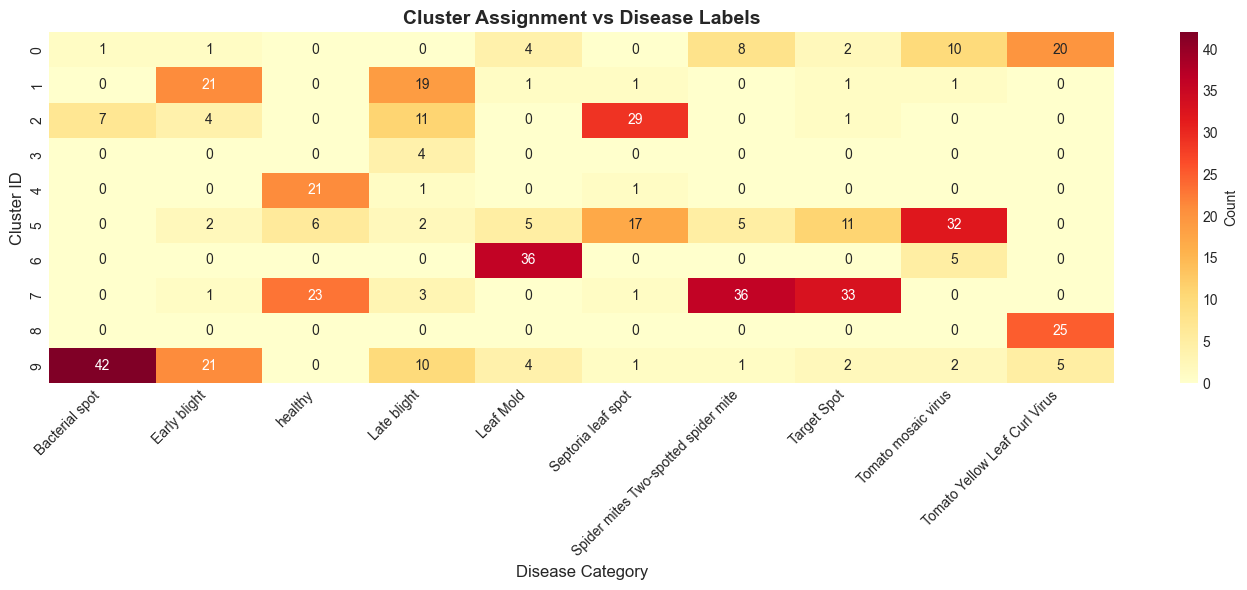


✓ Cluster-Disease correlation analysis complete


In [14]:
# Cross-tabulation: Clusters vs Original Disease Labels
crosstab = pd.crosstab(
    labels_kmeans,
    labels,
    rownames=['Cluster'],
    colnames=['Disease']
)

# Replace indices with class names
crosstab.columns = [idx_to_class[i].replace('Tomato___', '').replace('_', ' ') for i in crosstab.columns]

print("\nCluster vs Disease Label Cross-Tabulation:")
print(crosstab)

# Heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Count'})
plt.title('Cluster Assignment vs Disease Labels', fontsize=14, fontweight='bold')
plt.xlabel('Disease Category', fontsize=12)
plt.ylabel('Cluster ID', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(BASE_DIR / 'notebooks' / 'cluster_vs_disease.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cluster-Disease correlation analysis complete")

## 15. Save Models and Results

In [15]:
# Save models and results
models_data = {
    'scaler': scaler,
    'pca': pca,
    'kmeans': kmeans,
    'hierarchical_labels': labels_hierarchical,
    'features_pca': features_pca,
    'labels_kmeans': labels_kmeans,
    'labels_hierarchical': labels_hierarchical,
    'cluster_profiles': cluster_profiles,
    'metrics': {
        'kmeans': {
            'silhouette': silhouette_kmeans,
            'calinski': calinski_kmeans,
            'davies_bouldin': davies_bouldin_kmeans
        },
        'hierarchical': {
            'silhouette': silhouette_hier,
            'calinski': calinski_hier,
            'davies_bouldin': davies_bouldin_hier
        }
    }
}

output_path = BASE_DIR / 'clustering_results.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(models_data, f)

print(f"✓ Models and results saved to: {output_path}")
print(f"\nSaved objects:")
print(f"  • StandardScaler")
print(f"  • PCA model ({N_COMPONENTS} components)")
print(f"  • K-means model (k={N_CLUSTERS_KMEANS})")
print(f"  • Hierarchical clustering labels")
print(f"  • PCA-transformed features")
print(f"  • Cluster labels")
print(f"  • Cluster profiles")
print(f"  • Performance metrics")

✓ Models and results saved to: C:\Users\Champion\Documents\GitHub\term-project\clustering_results.pkl

Saved objects:
  • StandardScaler
  • PCA model (50 components)
  • K-means model (k=10)
  • Hierarchical clustering labels
  • PCA-transformed features
  • Cluster labels
  • Cluster profiles
  • Performance metrics


## 16. Summary

In [16]:
print("\n" + "="*80)
print("CLUSTERING ANALYSIS SUMMARY")
print("="*80)

print("\n✓ DIMENSIONALITY REDUCTION:")
print(f"   • Original features: {features.shape[1]}D")
print(f"   • Reduced features: {N_COMPONENTS}D")
print(f"   • Explained variance: {explained_variance_cumsum[-1]*100:.2f}%")
print(f"   • Components for 95% variance: {n_for_95}")

print("\n✓ K-MEANS CLUSTERING:")
print(f"   • Number of clusters: {N_CLUSTERS_KMEANS}")
print(f"   • Initializations: {KMEANS_N_INIT}")
print(f"   • Silhouette score: {silhouette_kmeans:.4f}")
print(f"   • Selection method: Elbow method + Silhouette analysis")

print("\n✓ HIERARCHICAL CLUSTERING:")
print(f"   • Number of clusters: {N_CLUSTERS_HIERARCHICAL}")
print(f"   • Linkage method: {LINKAGE_METHOD}")
print(f"   • Silhouette score: {silhouette_hier:.4f}")

print("\n✓ CLUSTER INTERPRETATION:")
for profile in cluster_profiles:
    print(f"   • Cluster {profile['cluster_id']}: {profile['engineering_analogy']}")

print("\n✓ OUTPUTS GENERATED:")
print("   • pca_variance.png - PCA explained variance")
print("   • elbow_method.png - Optimal k selection")
print("   • texture_space_2d.png - 2D visualization")
print("   • texture_space_3d.png - 3D visualization")
print("   • dendrogram.png - Hierarchical clustering")
print("   • cluster_vs_disease.png - Correlation heatmap")
print("   • cluster_profiles.csv - Engineering parameters")
print("   • clustering_results.pkl - All models and results")

print("\n✓ NEXT STEPS:")
print("   • Train CNN classifier for disease detection (Notebook 05)")
print("   • Demonstrate dual application framework (Notebook 06)")
print("   • Use cluster profiles for biomimetic design")
print("="*80)

print("\n✓ Clustering analysis complete!")


CLUSTERING ANALYSIS SUMMARY

✓ DIMENSIONALITY REDUCTION:
   • Original features: 1351D
   • Reduced features: 50D
   • Explained variance: 70.74%
   • Components for 95% variance: 1

✓ K-MEANS CLUSTERING:
   • Number of clusters: 10
   • Initializations: 100
   • Silhouette score: 0.0801
   • Selection method: Elbow method + Silhouette analysis

✓ HIERARCHICAL CLUSTERING:
   • Number of clusters: 10
   • Linkage method: ward
   • Silhouette score: 0.0669

✓ CLUSTER INTERPRETATION:
   • Cluster 0: Sandblasted surface (rough, irregular)
   • Cluster 1: Sandblasted surface (rough, irregular)
   • Cluster 2: Sandblasted surface (rough, irregular)
   • Cluster 3: Dimpled texture (discrete roughness features)
   • Cluster 4: Sandblasted surface (rough, irregular)
   • Cluster 5: Sandblasted surface (rough, irregular)
   • Cluster 6: Sandblasted surface (rough, irregular)
   • Cluster 7: Sandblasted surface (rough, irregular)
   • Cluster 8: Honed surface (directional grooves)
   • Cluster 9